In [1]:
# Set path to the parent directory
import sys
sys.path.append('../') # let you import from parent directory

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image


import cv2
import os
import numpy as np
from sklearn.metrics import accuracy_score

import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from tqdm import tqdm
import csv

# Import .py files and their functions
from bbox import rot, get_bbox
from utils import save_images, write_paths, write_labels, write_rotation_vectors, \
                    write_centroids, write_sizes, write_clouds, write_camera_matrices

c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


class, Type, Label:
[['0' 'Unknown' '0']
 ['1' 'Compacts' '1']
 ['2' 'Sedans' '1']
 ['3' 'SUVs' '1']
 ['4' 'Coupes' '1']
 ['5' 'Muscle' '1']
 ['6' 'SportsClassics' '1']
 ['7' 'Sports' '1']
 ['8' 'Super' '1']
 ['9' 'Motorcycles' '2']
 ['10' 'OffRoad' '2']
 ['11' 'Industrial' '2']
 ['12' 'Utility' '2']
 ['13' 'Vans' '2']
 ['14' 'Cycles' '2']
 ['15' 'Boats' '0']
 ['16' 'Helicopters' '0']
 ['17' 'Planes' '0']
 ['18' 'Service' '0']
 ['19' 'Emergency' '0']
 ['20' 'Military' '0']
 ['21' 'Commercial' '0']
 ['22' 'Trains' '0']]

labels: [0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 0 0 0 0 0 0 0]


In [2]:
# Collect and save labels, centroids, point clouds, and camera matrices data
path = 'trainval' # path to folder containing training snapshots, bbox.bin, cloud.bin, proj.bin

# Test Images
if not os.path.exists('./test/test_images.npy'):
    save_images('test') # trainval_paths.npy

# File Paths
if not os.path.exists('./trainval/trainval_paths.npy'):
    write_paths(path) # trainval_paths.npy

if not os.path.exists('./test/test_paths.npy'):
    write_paths('test') # test_paths.npy

# Labels of Bounding Boxes
if not os.path.exists('./trainval/trainval_labels.npy'):
    write_labels(path) # trainval_labels.npy

# Bounding Box Features - Rotation Vectors
if not os.path.exists('./trainval/trainval_rotation_vectors.npy'):
    write_rotation_vectors(path) # trainval_rotations.npy

# Bounding Box Features - Centroids
if not os.path.exists('./trainval/trainval_centroids.npy'):
    write_centroids(path) # trainval_centroids.npy

# Bounding Box Features - Sizes
if not os.path.exists('./trainval/trainval_sizes.npy'):
    write_sizes(path) # trainval_sizes.npy

# Camera Matrices
if not os.path.exists('./trainval/trainval_camera_matrices.npy'):
    write_camera_matrices(path) # trainval_camera_matrices.npy

In [3]:
# Root directory for training data
train_root = './trainval/'
test_root = './test/'

# Load data
train_images = glob('trainval/*/*_image.jpg') # Grab all the training snapshot image paths
test_images = np.load('test/test_images.npy') # Grab all the test snapshot images
train_paths = np.load(train_root + 'trainval_paths.npy') # each training data's path (for reference)
test_paths = np.load(test_root + 'test_paths.npy') # each test data's path (for reference)
labels = np.load(train_root + 'trainval_labels.npy')
rotation_vectors = np.load(train_root + 'trainval_rotation_vectors.npy')
centroids = np.load(train_root + 'trainval_centroids.npy')
sizes = np.load(train_root + 'trainval_sizes.npy')
camera_matrices = np.load(train_root + 'trainval_camera_matrices.npy', allow_pickle=True)

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def crop_bbox(image, rotation_vector, centroid, size, camera_matrix):
    """
    Convert 3D bounding box to 2D bounding box and crop the object from the image.
    """

    proj = camera_matrix

    R = rot(rotation_vector)
    t = centroid
    sz = size

    vert_3D, edges = get_bbox(-sz / 2, sz / 2)

    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]

    x_array = []
    y_array = []
    for e in edges.T:
        x_array.append(vert_2D[0, e])
        y_array.append(vert_2D[1, e])
        # plt.plot(vert_2D[0, e], vert_2D[1, e], 'r-')
    x_array = np.clip(np.array(x_array), 0, image.shape[1]-1) # clip to prevent bbox out of image
    y_array = np.clip(np.array(y_array), 0, image.shape[0]-1) # clip to prevent bbox out of image
    x_array = torch.from_numpy(x_array)
    y_array = torch.from_numpy(y_array)

    x_min = torch.min(x_array)
    x_max = torch.max(x_array)
    y_min = torch.min(y_array)
    y_max = torch.max(y_array)

    if x_min == x_max:
        x_min -= 1
        x_max += 1
    elif y_min == y_max:
        y_min -= 1
        y_max += 1

    object_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
    object_image = Image.fromarray(object_image)
    object_image = object_image.resize((224, 224))
    # object_image = np.array(object_image)

    return object_image


In [5]:
# Create a custom dataset class
class VehicleDataset(Dataset):
    def __init__(self, images, rotation_vectors, centroids, sizes, camera_matrices, labels, paths):
        self.images = images
        self.rotation_vectors = rotation_vectors
        self.centroids = centroids
        self.sizes = sizes
        self.camera_matrices = camera_matrices
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = plt.imread(self.images[idx])
        rotation_vector = self.rotation_vectors[idx]
        centroid = self.centroids[idx]
        size = self.sizes[idx]
        camera_matrix = self.camera_matrices[idx]
        label = self.labels[idx]

        cropped_image = crop_bbox(image, rotation_vector, centroid, size, camera_matrix)

        return cropped_image, label

1937


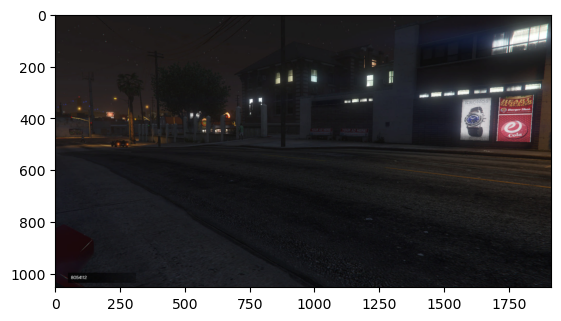

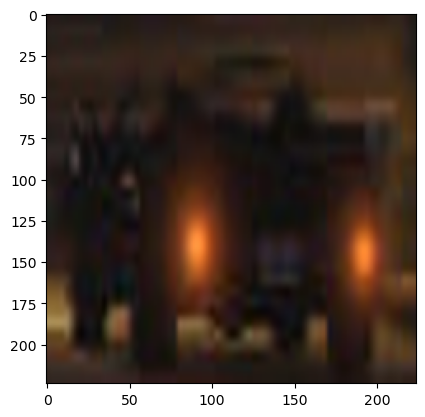

In [6]:
# Example
idxx = random.randint(0, len(train_images))
print(idxx)
zz=crop_bbox(plt.imread(train_images[idxx]), rotation_vectors[idxx], centroids[idxx], sizes[idxx], camera_matrices[idxx])
plt.imshow(plt.imread(train_images[idxx])) # image
# plt.plot(xx,yy) # 3D bounding box
plt.show()

plt.imshow(zz) # cropped image based on 2D bounding box
plt.show()

In [7]:
# Train + Val dataset
trainval_dataset = VehicleDataset(train_images, rotation_vectors, centroids, 
                                  sizes, camera_matrices, labels, train_paths)

# Train Val Split
train_size = int(0.8 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# Extract features from the images using a pre-trained model
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1])) # Remove the last layer to get features
resnet = resnet.to(device)
resnet.eval()

transform_train = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def extract_features_train(dataset):
    features = []
    labels = []
    with torch.no_grad():
        for img, label in tqdm(dataset, desc='Extracting features from training images'):
            img = transform_train(img)
            img = img.unsqueeze(0)
            img = img.to(device)
            feature = resnet(img).squeeze().cpu().numpy()
            features.append(feature)
            labels.append(label)
    return np.array(features), np.array(labels)


c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\whdqk\anaconda3\envs\sam\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
num_classes = len(set(labels)) # number of classes

X_train, y_train = extract_features_train(train_dataset)
X_val, y_val = extract_features_train(val_dataset)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = X_train.shape[1]
simple_nn = SimpleNN(input_size, num_classes)
simple_nn = simple_nn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_nn.parameters(), lr=0.001)
num_epochs = 50

# Training
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(X_train)):
        inputs = torch.tensor(X_train[i], dtype=torch.float).unsqueeze(0).to(device)
        labels = torch.tensor(y_train[i], dtype=torch.long).unsqueeze(0).to(device)

        optimizer.zero_grad()

        outputs = simple_nn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(X_train):.4f}")

# Evaluate the simple neural network on the validation set
simple_nn.eval()
correct = 0
total = 0
with torch.no_grad():
    for i in range(len(X_val)):
        inputs = torch.tensor(X_val[i], dtype=torch.float).unsqueeze(0).to(device)
        labels = torch.tensor(y_val[i], dtype=torch.long).unsqueeze(0).to(device)

        outputs = simple_nn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy:", 100 * correct / total)


Extracting features from training images: 100%|██████████| 1515/1515 [02:46<00:00,  9.10it/s]


Epoch 1/50, Loss: 0.5447
Epoch 2/50, Loss: 0.4176
Epoch 3/50, Loss: 0.3771
Epoch 4/50, Loss: 0.3437
Epoch 5/50, Loss: 0.3205
Epoch 6/50, Loss: 0.2921
Epoch 7/50, Loss: 0.2702
Epoch 8/50, Loss: 0.2491
Epoch 9/50, Loss: 0.2317
Epoch 10/50, Loss: 0.2194
Epoch 11/50, Loss: 0.2003
Epoch 12/50, Loss: 0.1909
Epoch 13/50, Loss: 0.1780
Epoch 14/50, Loss: 0.1712
Epoch 15/50, Loss: 0.1672
Epoch 16/50, Loss: 0.1589
Epoch 17/50, Loss: 0.1472
Epoch 18/50, Loss: 0.1442
Epoch 19/50, Loss: 0.1320
Epoch 20/50, Loss: 0.1359
Epoch 21/50, Loss: 0.1383
Epoch 22/50, Loss: 0.1258
Epoch 23/50, Loss: 0.1229
Epoch 24/50, Loss: 0.1181
Epoch 25/50, Loss: 0.1201
Epoch 26/50, Loss: 0.1068
Epoch 27/50, Loss: 0.1026
Epoch 28/50, Loss: 0.1036
Epoch 29/50, Loss: 0.0977
Epoch 30/50, Loss: 0.1011
Epoch 31/50, Loss: 0.0976
Epoch 32/50, Loss: 0.0976
Epoch 33/50, Loss: 0.1014
Epoch 34/50, Loss: 0.0908
Epoch 35/50, Loss: 0.0870
Epoch 36/50, Loss: 0.0846
Epoch 37/50, Loss: 0.1004
Epoch 38/50, Loss: 0.0785
Epoch 39/50, Loss: 0.

In [9]:
class VehicleFullImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = plt.imread(self.images[idx])
        image = Image.fromarray(image)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create a new dataset for fine-tuning with full images
fine_tune_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


labels = np.load(train_root + 'trainval_labels.npy')
fine_tune_dataset = VehicleFullImageDataset(train_images, labels, fine_tune_transform)

# Split the new dataset into training and validation subsets
train_size = int(0.8 * len(fine_tune_dataset))
val_size = len(fine_tune_dataset) - train_size

fine_tune_train_dataset, fine_tune_val_dataset = random_split(fine_tune_dataset, [train_size, val_size])

# Create data loaders for the fine-tuning datasets
batch_size = 32

fine_tune_train_loader = DataLoader(fine_tune_train_dataset, batch_size=batch_size, shuffle=True)
fine_tune_val_loader = DataLoader(fine_tune_val_dataset, batch_size=batch_size, shuffle=False)

# Use the pre-trained ResNet model
tuning_model = models.resnet18(pretrained=True)
tuning_model = tuning_model.to(device)

# Replace the last layer with a new fully connected layer for classification
tuning_model.fc = simple_nn

# Set a smaller learning rate for fine-tuning
fine_tune_lr = 0.0001
optimizer = optim.SGD(tuning_model.parameters(), lr=fine_tune_lr, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

# Train the model for a few more epochs
fine_tune_epochs = 8
tuning_model = tuning_model.to(device)

for epoch in range(1, fine_tune_epochs + 1):
    # Training loop
    tuning_model.train()
    running_loss = 0.0
    for i, (image_batch, label_batch) in tqdm(enumerate(fine_tune_train_loader, 1), total=len(fine_tune_train_loader)):
        input_batch, label_batch = image_batch.to(device), label_batch.to(device)

        optimizer.zero_grad()
        outputs = tuning_model(input_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    tuning_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_batch, label_batch in fine_tune_val_loader:
            input_batch, label_batch = input_batch.to(device), label_batch.to(device)

            outputs = tuning_model(input_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += label_batch.size(0)
            correct += (predicted == label_batch).sum().item()

    # Print the epoch summary
    print(f"Epoch {epoch}/{fine_tune_epochs}, "
          f"Loss: {running_loss / len(fine_tune_train_loader):.4f}, "
          f"Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 190/190 [12:01<00:00,  3.80s/it]


Epoch 1/8, Loss: 3.7433, Accuracy: 81.85%


100%|██████████| 190/190 [12:00<00:00,  3.79s/it]


Epoch 2/8, Loss: 0.6321, Accuracy: 86.53%


100%|██████████| 190/190 [12:06<00:00,  3.82s/it]


Epoch 3/8, Loss: 0.2806, Accuracy: 87.26%


100%|██████████| 190/190 [11:51<00:00,  3.75s/it]


Epoch 4/8, Loss: 0.1650, Accuracy: 88.45%


100%|██████████| 190/190 [08:38<00:00,  2.73s/it]


Epoch 5/8, Loss: 0.1017, Accuracy: 89.24%


100%|██████████| 190/190 [08:51<00:00,  2.80s/it]


Epoch 6/8, Loss: 0.0824, Accuracy: 90.03%


100%|██████████| 190/190 [08:35<00:00,  2.71s/it]


Epoch 7/8, Loss: 0.0514, Accuracy: 90.36%


100%|██████████| 190/190 [08:13<00:00,  2.60s/it]


Epoch 8/8, Loss: 0.0556, Accuracy: 90.63%


In [10]:
class VehicleTestImageDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_batch_size = 1

test_image_dataset = VehicleTestImageDataset(test_images, test_transform)
test_image_loader = DataLoader(test_image_dataset, batch_size=test_batch_size, shuffle=False)

tuning_model.eval()
test_predictions = []

with torch.no_grad():
    for inputs in tqdm(test_image_loader):
        inputs = inputs.to(device)

        outputs = tuning_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_predictions.extend(predicted.cpu().numpy())

with open('test_predictions_resnet_simpleNN.csv', 'w', newline='') as f:
    csv_writer = csv.writer(f)

    # Write the header
    csv_writer.writerow(["guid/image", "label"])

    for i, pred in tqdm(enumerate(test_predictions), desc='Saving predictions to file'):
        csv_writer.writerow([test_paths[i], pred])


100%|██████████| 2631/2631 [01:58<00:00, 22.26it/s]
Saving predictions to file: 2631it [00:00, 177892.63it/s]


In [11]:
# idxx = 414

# xx=object_detection_model(transform_test(test_images[idxx]).unsqueeze(0))
# xx[0]['boxes'].shape[0]
# xx = xx[0]['boxes'][0]
# x_min, y_min, x_max, y_max = map(int, xx)
# plt.imshow(test_images[idxx][y_min:y_max, x_min:x_max])